### Note: The proposed improvements to the basic transformer model are below the baseline version of the model in this file. (See Part 2)

In [12]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
a
import matplotlib.pyplot as plt
from tqdm import tqdm

import requests
import os

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# Global hyperparameters
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

In [14]:
# download the tiny shakespeare dataset
input_file_path = 'input.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


In [15]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [16]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_chars = data[:int(n*0.9)]
val_chars = data[int(n*0.9):]

# encode both to integers
train_data = encode(train_chars)
val_data = encode(val_chars)

# cast as torch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")

train has 1,003,854 tokens
val has 111,540 tokens


In [17]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))  # generate a bunch of starting positions
    x = torch.stack([data[i:i+context_window_size] for i in ix]) # stack the data from each starting point
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [18]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size))) # lower diagonal matrix

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # attn_weights = torch.einsum('btd, btd -> btt', self.query(x), self.key(x)) # (B,T)
        # attn_weights = self.query(x) @ self.key(x).transpose(1,2) # (B,T,T)

        attn_weights = self.query(x) @ self.key(x).transpose(-2,-1) # (B,T,T)
        # (self.query(x) @ self.key(x).transpose(1,2)).shape # (B,T,T)
        # if len(attn_weights.shape) == 2:
        #     attn_weights = attn_weights.unsqueeze(0)
        attn_weights = attn_weights.masked_fill((self.tril==0)[0:attn_weights.shape[1],0:attn_weights.shape[2]], float('-inf')) # (B,T,T)
        attn_weights = F.softmax(attn_weights/(self.head_size**(1/2)), dim=-1) # (B,T,T)
        # if len(attn_weights.shape) == 2:
        #     avg_embeddings = torch.einsum('tt, td -> td', attn_weights, self.value(x)) #
        # else:

        # avg_embeddings = torch.einsum('btt, btd -> btd', attn_weights, self.value(x)) # (B,T,D) # self.value(x) gives (B,T,D), attn_weights gives (B,T)
        avg_embeddings = torch.einsum('bij,bjd->bid', attn_weights, self.value(x))
        return avg_embeddings



        # pass

In [19]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size) # X which we will pass to the head
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size) # as in part 1.2, we learn a beta matrix to get logits. See "autoregressive modeling" slide, W\in \R^VxD, st l_{t+1} = Cat(Wx_t)
      self.vocab_size = vocab_size
      self.embed_size = embed_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """


        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        # logits =
        loss_fcn = torch.nn.CrossEntropyLoss()
        loss = loss_fcn(logits.reshape(-1, self.vocab_size), targets.reshape(-1)) # as before

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):


        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        #feels janky to for loop this but dont see a choice?

        for i in range(max_new_tokens):
            B, T = token_ids.shape # (batch size, length)
            tok_emb = self.token_embedding_table(token_ids[:,-self.context_window_size:]) # (B,T,D)
            pos_emb = self.position_embedding_table(torch.arange(self.context_window_size, device=device)) # (T,D)
            x = tok_emb + pos_emb # (B,T,D)
            x = self.atten_head(x) # (B,T,D)
            logits = self.lm_head(x) # (B,T,V)
            new_token = torch.argmax(logits[:,-1],dim=1) # best token for each batch
            token_ids = torch.cat([token_ids,new_token.unsqueeze(1)],dim=1)

        # return decode(token_ids.tolist())
        return token_ids

        # pass

In [20]:
embed_size = 384
sha_model = SingleHeadedAttentionLM(vocab_size, CONTEXT_WINDOW_SIZE, embed_size, embed_size)
sham = sha_model.to(device)
learning_rate = 6e-4
optimizer = torch.optim.AdamW(sha_model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(sham, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = sham(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  1%|          | 11/1000 [00:01<01:16, 12.94it/s]

step 0: train loss 4.1781, val loss 4.1782


 20%|██        | 200/1000 [00:03<00:10, 77.77it/s]

iteration 200


 22%|██▏       | 216/1000 [00:04<00:28, 27.42it/s]

step 200: train loss 2.5814, val loss 2.5836


 40%|███▉      | 396/1000 [00:06<00:07, 76.59it/s]

iteration 400


 41%|████      | 412/1000 [00:08<00:22, 26.36it/s]

step 400: train loss 2.5230, val loss 2.5427


 60%|█████▉    | 597/1000 [00:10<00:06, 60.31it/s]

iteration 600


 60%|██████    | 604/1000 [00:12<00:33, 11.86it/s]

step 600: train loss 2.4219, val loss 2.4518


 80%|███████▉  | 798/1000 [00:16<00:03, 56.29it/s]

iteration 800


 81%|████████  | 810/1000 [00:18<00:11, 16.44it/s]

step 800: train loss 2.3838, val loss 2.4197


100%|█████████▉| 998/1000 [00:20<00:00, 74.94it/s]

iteration 999


100%|██████████| 1000/1000 [00:21<00:00, 46.38it/s]

step 999: train loss 2.3572, val loss 2.3973


In [21]:
tokens_out = sha_model.generate(xb, max_new_tokens=100)
decode(tokens_out[20,250:].tolist())

'loss and the the the the the the the the the the the the the the the the the the the the the the the the t'

In [22]:
import seaborn as sns

Text(0, 0.5, 'Loss')

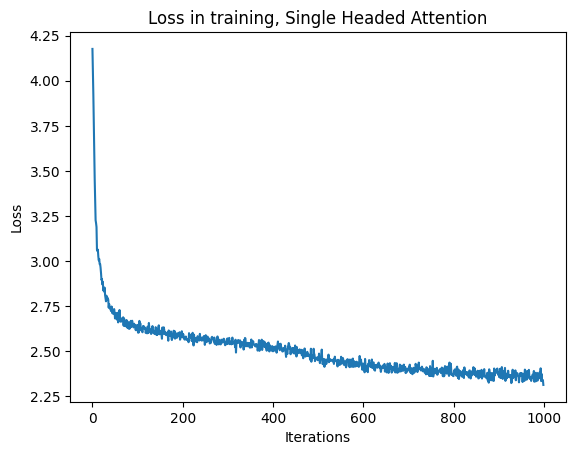

In [23]:
sns.lineplot(x=range(SMALL_ITERS), y=loss_list)
plt.title("Loss in training, Single Headed Attention")
plt.xlabel("Iterations")
plt.ylabel("Loss")

---

In terms of training loss we definitely see an improvement. In particular the loss decreases to approximately 2, however it is slightly noisier around the optima.

---

#### 1.3.3: Multi-headed attention

##### Question 1.3.3.1: Implement multi-headed attention

In [24]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_window_size, num_heads, head_size, embed_size=384):
        """
        Args:
            context_window_size: int, number of tokens considered in the past for attention (T)
            num_heads: int, number of heads (H)
            head_size: int, size of the head embedding dimension
            embed_size: int, size of the token embedding dimension
        """
        super().__init__()
        # TODO, your code below
        self.heads = nn.ModuleList([Head(head_size, context_window_size, embed_size) for _ in range(num_heads)])
        self.num_heads = num_heads

        # could also learn a map from the concatenated heads to the output space ?



    def forward(self, x): # x is (B,T,D)
        # TODO, your code below
        heads = [head(x) for head in self.heads] # list of (B,T,D)
        # approach 1
        avg_embeddings = torch.stack(heads).sum(dim=0) # (B,T,D) - just sum across heads elementwise for each token
        return avg_embeddings
        # pass

##### Question 1.3.3.2: Implement a multi-headed attention LM

Fill in the code below to create a language model that outputs its logits for next token prediction using multi-headed attention. Train your model for `SMALL_ITERS` training iterations. Compare the results with the single-headed attention model. Do you see an improvement?

We get to a train loss of around 2 after 1000 iterations, which takes around 1.5 minutes on a T4 GPU.

In [25]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size) # X which we will pass to the head
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.atten_head = MultiHeadAttention(context_window_size, num_heads, self.head_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)
      self.vocab_size = vocab_size
      self.embed_size = embed_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below

        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)
        loss_fcn = torch.nn.CrossEntropyLoss()
        loss = loss_fcn(logits.reshape(-1, self.vocab_size), targets.reshape(-1)) # as before

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        pass

In [28]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

In [29]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size) # acts along rows x_t^(m+1) = mlp(y_t^(m))
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size//num_heads, embed_size) # as before
        self.vocab_size = vocab_size
        self.embed_size = embed_size


    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length y_t^(m) = atten_heads(x_t^(m))
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space x_t^(m+1) = mlp(y_t^(m))
        return x

In [30]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)]) # chains output of one block to input of next. Output of self.blocks is x_t^M

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.vocab_size = vocab_size

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        x = self.blocks(x) # instead of just x=self.attention_head(x), x is processed through a sequence of transformer blocks, each first processed by "self attn" then by mlp.
        # this x is x_t^M in Scott's notes
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss_fcn = torch.nn.CrossEntropyLoss()
        loss = loss_fcn(logits.reshape(-1, self.vocab_size), targets.reshape(-1)) # as before


        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate

        """
        # if token_ids.shape[0] ==1:
        #     token_ids = token_ids.unsqueeze(0)
        #     token_ids = token_ids.unsqueeze(0)

        for i in range(max_new_tokens):
            B, T = token_ids.shape # (batch size, length)
            t = min(CONTEXT_WINDOW_SIZE,T)
            tok_emb = self.token_embedding_table(token_ids[:,-t:]).reshape(B,t,-1) # (B,T,D)
            pos_emb = self.position_embedding_table(torch.arange(t, device=device)) # (T,D)
            x = tok_emb + pos_emb # (B,T,D)
            x = self.blocks(x) # (B,T,D)
            x= self.ln_f(x)
            logits = self.lm_head(x) # (B,T,V)
            # if len(logits.shape) == 2:
            #     new_token = torch.argmax(logits[-1,:])
            # else:
            #     new_token = torch.argmax(logits[:,-1],dim=1)
            # new_token = torch.argmax(logits[:,-1],dim=1) # best token for each batch
            new_token = torch.distributions.Categorical(logits=logits[:,-1]).sample()
            # token_ids = torch.cat([token_ids,new_token.unsqueeze(0)],dim=1)
            token_ids = torch.cat([token_ids,new_token.unsqueeze(1)],dim=1)

    # return decode(token_ids.tolist())
        return token_ids
        # pass

Train your `TransformerLM` for `LARGE_ITERS` iterations and plot the loss curve. You may want to change the learning rate.

We used a learning rate of `1e-4` and got to a final train loss of around 1.4 in around 15 minutes of training on a T4 GPU.

In [ ]:
# conditional generation from the model

context1 = """ROMEO:
He jests at scars that never felt a wound.
But, soft! what light through yonder window breaks?
It is the east, and Juliet is the sun.
Arise, fair sun, and kill the envious moon,
Who is already sick and pale with grief,
That thou her maid art far more fair than she:
Be not her maid, """

# context1_tokens = torch.tensor(encode(context1), device=device).reshape(1, -1)

## Part 2: Mini-Project

Quick recap: So far we have

1. Preprocessed the Shakespeare dataset by encoding individual characters into integer tokens.
2. Implemented single headed attention and then further generalized to multiheaded attention. We further combined multiheaded attention with deep learning to create the transformer architecture.
3. Trained our transformer and generated output that looks to be in the style of Shakespeare.

Up to this point, the performance of our simple language model has clearly made a lot of progress. We can see that our model has learned to generate text that is close to the style of Shakespeare, although there are still many quirks and room for improvement.

### Project Outline

Find some area of possible improvement.
We interpret "improvement" quite loosely, but please state precisely why your proposed innovation might improve the model, and provide evidence that it does (or does not!) improve.
For your idea, **formulate a hypothesis** for why this change should result in a better model. **Implement your changes** and **report any findings**.

_Notes_: As this assignment is being treated as a project, you should expect training to take longer than previous assignments. However, please use your judgement to decide what is reasonable. We will not expect you to run training procedures that take more than 2 hours on the free Google Colab computing resources and we certainly do not expect you to acquire additional compute. The proposed improvements should not solely rely on increased computing demands.

_Hints_: There are many aspects to assessing a model. For example, not only is quality of generated text important, it is also of interest to reduce costs associated with training.

### Deliverables

In addition to a pdf of your python notebook, the submission for this project will be a written report no more than 4 pages in length using the [NeurIPS LaTex template](https://neurips.cc/Conferences/2023/PaperInformation/StyleFiles). Your report should include detailed analysis of the hypotheses you chose to test along with any conclusions.

The page limit for the report does not include bibliography or appendices. Make sure to keep the "ready for submission" option to help us grade anonymously. Your writeup should also contain a link to any code used to generate the project so that we can reference it while grading (Google Drive folder with colab notebooks or Github repo are both fine). You should have at least one plot in your main text (which is capped at 4 pages).

### TransformerLM_2 is has Dropout added to the output of the attention and mlp layers

In [32]:
class TransformerBlock_2(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6,dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size) # acts along rows x_t^(m+1) = mlp(y_t^(m))
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size//num_heads, embed_size) # as before
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        # for dropout

        self.dropout = nn.Dropout(dropout) # takes a dropout rate arg



    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length y_t^(m) = atten_heads(x_t^(m))
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space x_t^(m+1) = mlp(y_t^(m))



        # for adding dropout
        # x = x + self.dropout(self.atten_heads(self.ln1(x))) # communication over sequence length y_t^(m) = atten_heads(x_t^(m))
        # x = x + self.dropout(self.feed_forward(self.ln2(x))) # communication across embedding space x_t^(m+1) = mlp(y_t^(m))
        return x

In [33]:
class TransformerLM_2(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock_2(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)]) # chains output of one block to input of next. Output of self.blocks is x_t^M

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.vocab_size = vocab_size

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        x = self.blocks(x) # instead of just x=self.attention_head(x), x is processed through a sequence of transformer blocks, each first processed by "self attn" then by mlp.
        # this x is x_t^M in Scott's notes
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss_fcn = torch.nn.CrossEntropyLoss()
        loss = loss_fcn(logits.reshape(-1, self.vocab_size), targets.reshape(-1)) # as before


        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate

        """
        # if token_ids.shape[0] ==1:
        #     token_ids = token_ids.unsqueeze(0)
        #     token_ids = token_ids.unsqueeze(0)

        for i in range(max_new_tokens):
            B, T = token_ids.shape # (batch size, length)
            t = min(CONTEXT_WINDOW_SIZE,T)
            tok_emb = self.token_embedding_table(token_ids[:,-t:]).reshape(B,t,-1) # (B,T,D)
            pos_emb = self.position_embedding_table(torch.arange(t, device=device)) # (T,D)
            x = tok_emb + pos_emb # (B,T,D)
            x = self.blocks(x) # (B,T,D)
            x= self.ln_f(x)
            logits = self.lm_head(x) # (B,T,V)
            # if len(logits.shape) == 2:
            #     new_token = torch.argmax(logits[-1,:])
            # else:
            #     new_token = torch.argmax(logits[:,-1],dim=1)
            # new_token = torch.argmax(logits[:,-1],dim=1) # best token for each batch
            new_token = torch.distributions.Categorical(logits=logits[:,-1]).sample()
            # token_ids = torch.cat([token_ids,new_token.unsqueeze(0)],dim=1)
            token_ids = torch.cat([token_ids,new_token.unsqueeze(1)],dim=1)

    # return decode(token_ids.tolist())
        return token_ids
        # pass

In [34]:
LARGE_ITERS = 4000

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

trans = TransformerLM_2(vocab_size, CONTEXT_WINDOW_SIZE)
tlm = trans.to(device)
learning_rate = 1e-4
# TODO, your code below

from torch.optim.lr_scheduler import CosineAnnealingLR
torch.manual_seed(760)

optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate)
# scheduler = CosineAnnealingLR(optimizer, T_max=LARGE_ITERS, eta_min=1e-6)

eval_interval = 200

# batch params
batch_start = 16
batch_max = 128
batch_growth = LARGE_ITERS//4


loss_list = []

for it in tqdm(range(LARGE_ITERS)):
    #update the batch size
    # batch_size = min(batch_start *(2**(it // batch_growth)), batch_max)
    batch_size = 32


    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == LARGE_ITERS - 1:
        print(f"iteration {it}", f"batch size {batch_size}")
        losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size=batch_size)
    optimizer.zero_grad(set_to_none=True)

    # evaluate the loss
    with autocast():
      logits, loss = tlm(xb, yb)
    # logits, loss = tlm(xb, yb)
    scaler.scale(loss).backward()

    # Gradient clipping (optional for stability)
    # torch.nn.utils.clip_grad_norm_(tlm.parameters(), 1)
    loss_list.append(loss.detach().item())

    # Step optimizer and scheduler with scaler
    scaler.step(optimizer)
    scaler.update()
    # scheduler.step()


<ipython-input-34-125e4dcc4c7a>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/4000 [00:00<?, ?it/s]

iteration 0 batch size 32
step 0: train loss 4.3019, val loss 4.2964


<ipython-input-34-125e4dcc4c7a>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  5%|▌         | 200/4000 [00:55<08:42,  7.28it/s]

iteration 200 batch size 32


  5%|▌         | 201/4000 [01:18<7:33:01,  7.15s/it]

step 200: train loss 2.5138, val loss 2.5184


 10%|█         | 400/4000 [01:47<08:24,  7.13it/s]

iteration 400 batch size 32


 10%|█         | 401/4000 [02:11<7:33:21,  7.56s/it]

step 400: train loss 2.3536, val loss 2.3647


 15%|█▌        | 600/4000 [02:39<07:48,  7.26it/s]

iteration 600 batch size 32


 15%|█▌        | 601/4000 [03:03<6:58:55,  7.39s/it]

step 600: train loss 2.0914, val loss 2.1333


 20%|██        | 800/4000 [03:31<07:24,  7.21it/s]

iteration 800 batch size 32


 20%|██        | 801/4000 [03:56<6:35:07,  7.41s/it]

step 800: train loss 1.8992, val loss 1.9926


 25%|██▌       | 1000/4000 [04:23<06:53,  7.25it/s]

iteration 1000 batch size 32


 25%|██▌       | 1001/4000 [04:48<6:10:16,  7.41s/it]

step 1000: train loss 1.7693, val loss 1.9050


 30%|███       | 1200/4000 [05:15<06:26,  7.24it/s]

iteration 1200 batch size 32


 30%|███       | 1201/4000 [05:40<5:45:24,  7.40s/it]

step 1200: train loss 1.6759, val loss 1.8464


 35%|███▌      | 1400/4000 [06:07<06:05,  7.11it/s]

iteration 1400 batch size 32


 35%|███▌      | 1401/4000 [06:32<5:20:47,  7.41s/it]

step 1400: train loss 1.6156, val loss 1.7857


 40%|████      | 1600/4000 [06:59<05:30,  7.25it/s]

iteration 1600 batch size 32


 40%|████      | 1601/4000 [07:24<4:56:14,  7.41s/it]

step 1600: train loss 1.5562, val loss 1.7306


 45%|████▌     | 1800/4000 [07:51<05:04,  7.23it/s]

iteration 1800 batch size 32


 45%|████▌     | 1801/4000 [08:16<4:31:28,  7.41s/it]

step 1800: train loss 1.5173, val loss 1.7000


 50%|█████     | 2000/4000 [08:43<04:41,  7.11it/s]

iteration 2000 batch size 32


 50%|█████     | 2001/4000 [09:08<4:06:54,  7.41s/it]

step 2000: train loss 1.4725, val loss 1.6705


 55%|█████▌    | 2200/4000 [09:35<04:08,  7.23it/s]

iteration 2200 batch size 32


 55%|█████▌    | 2201/4000 [10:00<3:42:03,  7.41s/it]

step 2200: train loss 1.4500, val loss 1.6604


 60%|██████    | 2400/4000 [10:27<03:40,  7.27it/s]

iteration 2400 batch size 32


 60%|██████    | 2401/4000 [10:52<3:17:28,  7.41s/it]

step 2400: train loss 1.4172, val loss 1.6371


 65%|██████▌   | 2600/4000 [11:19<03:14,  7.19it/s]

iteration 2600 batch size 32


 65%|██████▌   | 2601/4000 [11:44<2:52:53,  7.41s/it]

step 2600: train loss 1.3916, val loss 1.6149


 70%|███████   | 2800/4000 [12:11<02:50,  7.04it/s]

iteration 2800 batch size 32


 70%|███████   | 2801/4000 [12:36<2:28:07,  7.41s/it]

step 2800: train loss 1.3705, val loss 1.6068


 75%|███████▌  | 3000/4000 [13:03<02:17,  7.27it/s]

iteration 3000 batch size 32


 75%|███████▌  | 3001/4000 [13:28<2:03:20,  7.41s/it]

step 3000: train loss 1.3548, val loss 1.5872


 80%|████████  | 3200/4000 [13:55<01:50,  7.25it/s]

iteration 3200 batch size 32


 80%|████████  | 3201/4000 [14:20<1:38:39,  7.41s/it]

step 3200: train loss 1.3345, val loss 1.5939


 85%|████████▌ | 3400/4000 [14:47<01:25,  7.04it/s]

iteration 3400 batch size 32


 85%|████████▌ | 3401/4000 [15:12<1:14:01,  7.41s/it]

step 3400: train loss 1.3241, val loss 1.5827


 90%|█████████ | 3600/4000 [15:39<00:55,  7.25it/s]

iteration 3600 batch size 32


 90%|█████████ | 3601/4000 [16:04<49:16,  7.41s/it]

step 3600: train loss 1.3052, val loss 1.5845


 95%|█████████▌| 3800/4000 [16:31<00:27,  7.25it/s]

iteration 3800 batch size 32


 95%|█████████▌| 3801/4000 [16:56<24:34,  7.41s/it]

step 3800: train loss 1.2890, val loss 1.5737


100%|█████████▉| 3999/4000 [17:23<00:00,  7.24it/s]

iteration 3999 batch size 32


100%|██████████| 4000/4000 [17:47<00:00,  3.75it/s]

step 3999: train loss 1.2752, val loss 1.5648


Text(0, 0.5, 'Loss')

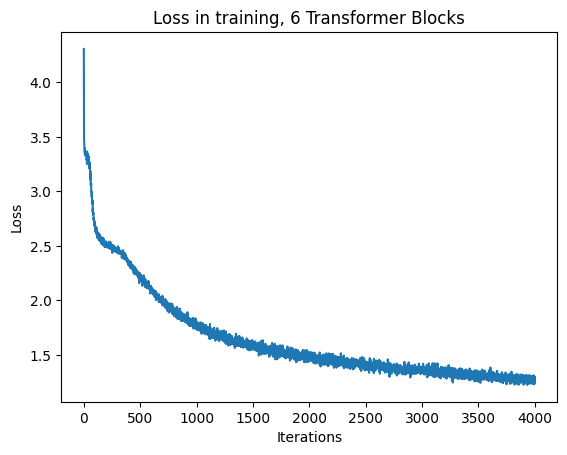

In [35]:
import seaborn as sns
sns.lineplot(x=range(LARGE_ITERS), y=loss_list)
plt.title("Loss in training, 6 Transformer Blocks")
plt.xlabel("Iterations")
plt.ylabel("Loss")

### Here I implement the variable attention model, per the meta paper

In [36]:
class MaskedHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)
        self.z = nn.Parameter(torch.randn(1)) # learnable parameter controlling attention span
        # I also tried making this a learnable parameter but seems the best strat is to fix at 10 as in the paper
        self.R = 10
        # self.R = nn.Parameter(torch.tensor(10.0))
        # also played with l1 regularization but decided not to include for simplicity
        self.lambda_reg = 0#1e-20
        self.cached_mask = None
        self.cached_T = None
        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size))) # lower diagonal matrix



    def compute_masking_matrix(self, z, R, T):
        # so that we don't recompute everytime
        if self.cached_mask is not None and self.cached_T == T and torch.allclose(self.cached_z, z):
            return self.cached_mask

        positions = torch.arange(T, device=z.device)
        distance_matrix = positions.unsqueeze(1) - positions.unsqueeze(0)
        distance_matrix = distance_matrix.abs()

        # as given in the meta paper
        mask = (1 / R) * (R + z - distance_matrix)
        mask = torch.clamp(mask, min=0, max=1)

        self.cached_mask = mask
        self.cached_T = T
        self.cached_z = z.detach().clone()

        return mask  # Shape: (T, T)

    def masked_attention(self, attn_scores):
        B, T, _ = attn_scores.shape
        mask = self.compute_masking_matrix(self.z, self.R, T).unsqueeze(0)
        log_mask = torch.log(mask.clamp(min=1e-10))
        masked_scores = attn_scores + log_mask #instead of multiplying just add the log before softmax
        attn_probs = torch.softmax(masked_scores, dim=-1)

        return attn_probs


    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """

        attn_weights = self.query(x) @ self.key(x).transpose(-2,-1) # (B,T,T)
        attn_weights = attn_weights.masked_fill((self.tril==0)[0:attn_weights.shape[1],0:attn_weights.shape[2]], float('-inf')) # (B,T,T)
        masked_attn_weights = self.masked_attention(attn_weights)
        avg_embeddings = torch.einsum('bij,bjd->bid', masked_attn_weights, self.value(x))
        l1_penalty = self.lambda_reg * self.z.abs().sum()

        return avg_embeddings,l1_penalty


class MultiHeadAttention_Masked(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_window_size, num_heads, head_size, embed_size=384):
        """
        Args:
            context_window_size: int, number of tokens considered in the past for attention (T)
            num_heads: int, number of heads (H)
            head_size: int, size of the head embedding dimension
            embed_size: int, size of the token embedding dimension
        """
        super().__init__()
        # TODO, your code below
        # had to change to module list to play nice with l1 penalty
        self.heads = nn.ModuleList([MaskedHead(head_size, context_window_size, embed_size) for _ in range(num_heads)])
        self.num_heads = num_heads


    def forward(self, x): # x is (B,T,D)
        # TODO, your code below
        heads = [head(x) for head in self.heads] # list of (B,T,D)
        avg_embeddings = torch.stack([h[0] for h in heads]).sum(dim=0) # (B,T,D) - just sum across heads elementwise for each token
        total_l1_penalty = sum(h[1] for h in heads) / self.num_heads  # Average L1 across heads
        return avg_embeddings, total_l1_penalty
        # pass
class TransformerBlock_VarAttn(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6,dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size) # acts along rows x_t^(m+1) = mlp(y_t^(m))
        self.atten_heads = MultiHeadAttention_Masked(context_window_size, num_heads, embed_size//num_heads, embed_size) # as before
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        # for dropout
        self.dropout = nn.Dropout(dropout) # takes a dropout rate arg

    def forward(self, x):
        attn_output, l1_penalty = self.atten_heads(self.ln1(x))
        x = x + self.dropout(attn_output)
        x = x + self.dropout(self.feed_forward(self.ln2(x)))
        return x, l1_penalty

class TransformerLM_VarAttn(nn.Module):
    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        # module list again bc l1_penalty
        self.blocks = nn.ModuleList([
            TransformerBlock_VarAttn(vocab_size, context_window_size, embed_size=embed_size, num_heads=num_heads)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.vocab_size = vocab_size

        # Good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Args:
            token_ids: (B, T) tensor of integers, provides the context
            targets: (B, T) tensor of integers, provides the tokens we are predicting
        """
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)  # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=token_ids.device))  # (T, D)
        x = tok_emb + pos_emb  # (B, T, D)

        total_l1_penalty = 0
        # does the sequential processing manually since using module list instead of sequential
        for block in self.blocks:
            x, l1_penalty = block(x)
            total_l1_penalty += l1_penalty

        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss_fcn = torch.nn.CrossEntropyLoss()
        loss = loss_fcn(logits.reshape(-1, self.vocab_size), targets.reshape(-1)) + total_l1_penalty

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: (B, T) tensor of integers forming the context.
            max_new_tokens: int, max number of tokens to generate.
        """
        for i in range(max_new_tokens):
            B, T = token_ids.shape  # (B, T)
            t = min(T, self.position_embedding_table.num_embeddings)
            tok_emb = self.token_embedding_table(token_ids[:, -t:]).reshape(B, t, -1)  # (B, T, D)
            pos_emb = self.position_embedding_table(torch.arange(t, device=token_ids.device))  # (T, D)
            x = tok_emb + pos_emb  # (B, T, D)
            for block in self.blocks:
                x, _ = block(x)
            x = self.ln_f(x)
            logits = self.lm_head(x)  # (B, T, V)
            new_token = torch.distributions.Categorical(logits=logits[:, -1]).sample()
            token_ids = torch.cat([token_ids, new_token.unsqueeze(1)], dim=1)
        return token_ids


### this code block updates train data according to how many bi and trigrams we include

In [37]:
# find the most common bigrams and trigrams (doubles and triple character combination)
from collections import Counter
#update this
n_biandtri = 250

# Ensure 'data' is defined with your full text
n = len(data)
train_chars = data[:int(n * 0.9)]
val_chars = data[int(n * 0.9):]

def BiandTrigrams(text, top=10):

    text = text.replace("\n", "").replace(" ", "")  # Remove spaces and newlines

    ngram_count = Counter()
    #pdb.st_trace()
    for size in [2,3]:
        ngrams = [text[i:i+size] for i in range(len(text) - size + 1)]
        ngram_count.update(ngrams)

    return [ngram for ngram, _ in ngram_count.most_common(top)]



out = BiandTrigrams(train_chars, n_biandtri)
#top 100 bigrams and trigrams

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))

dic = chars+list(out)

# create a mapping from dic tionary of integers and bi/trigrams to integers
stoi2 = { ch:i for i,ch in enumerate(dic) }
itos2 = { i:ch for i,ch in enumerate(dic) }

def encodeBiandTri(text):

    i = 0
    encoded_string = []
    while i < len(text):

        if i + 2 < len(text) and text[i:i+3] in stoi2:
            encoded_string.append(stoi2[text[i:i+3]])
            i += 3 #checks next three integers

        elif i + 1 < len(text) and text[i:i+2] in stoi2:
            encoded_string.append(stoi2[text[i:i+2]])
            i += 2
        # As above with doubles
        elif text[i] in stoi2:
            encoded_string.append(stoi2[text[i]])
            i += 1
        else:
            raise ValueError(f"Unknown token at index {i}: {text[i]}")
    return encoded_string

def decode2(l):
    return ''.join([itos2[i] for i in l]) # decoder: take a list of integers, output a string


# Encode both datasets into lists of integers
train_data = encodeBiandTri(train_chars)
val_data = encodeBiandTri(val_chars)

# Cast the lists to torch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")

vocab_size=len(dic)
print(f"Dictionary has {vocab_size} tokens")

train has 664,015 tokens
val has 75,083 tokens
Dictionary has 315 tokens


In [38]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))  # generate a bunch of starting positions
    x = torch.stack([data[i:i+context_window_size] for i in ix]) # stack the data from each starting point
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [39]:
LARGE_ITERS = 4000
import itertools

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# trans = TransformerLM_VarAttn(vocab_size, CONTEXT_WINDOW_SIZE)
trans = TransformerLM_2(vocab_size, CONTEXT_WINDOW_SIZE)
tlm = trans.to(device)
learning_rate = 1e-4
# TODO, your code below

from torch.optim.lr_scheduler import CosineAnnealingLR
torch.manual_seed(760)

optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW([
    {'params': [p for n, p in trans.named_parameters() if ('z' not in n and 'R' not in n)], 'lr': 1e-4},  # Default LR
    {'params': [p for n, p in trans.named_parameters() if ('z' in n or 'R' in n)], 'lr': 0.01}  # Higher LR for z
])
# scheduler = CosineAnnealingLR(optimizer, T_max=LARGE_ITERS, eta_min=1e-6)

eval_interval = 200

# batch params
batch_start = 16
batch_max = 128
batch_growth = LARGE_ITERS//4


loss_list = []
min_prev_val_loss = torch.tensor([100.]) #init
for it in tqdm(range(LARGE_ITERS)):
    #update the batch size
    # batch_size = min(batch_start *(2**(it // batch_growth)), batch_max)
    batch_size = 32


    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == LARGE_ITERS - 1:
        print(f"iteration {it}", f"batch size {batch_size}")
        losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)

        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # update minimum prev val loss
        min_prev_val_loss = torch.min(losses['val'],min_prev_val_loss)


        # zs = list(itertools.chain.from_iterable( [[10 + head.z.item() +1 for head in tlm.blocks[i].atten_heads.heads] for i in range(6)]))
        # Rs = list(itertools.chain.from_iterable( [[head.R  for head in tlm.blocks[i].atten_heads.heads] for i in range(6)]))


        # print(f'min z: {min(zs)}, max; {max(zs)}, min R {min(Rs)}, max R {max(Rs)}')
        # stop once our losses['val'] starts increasing
        if it > 0 and losses['val'] > 1.02*min_prev_val_loss:
            break

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size=batch_size)
    optimizer.zero_grad(set_to_none=True)

    # evaluate the loss
    with autocast():
      logits, loss = tlm(xb, yb)
    scaler.scale(loss).backward(retain_graph=True)

    # for head in tlm.blocks[0].atten_heads.heads:
    #     print(10 + head.z.item() +1)
    # messed around w grad clipping but decided not to include
    # torch.nn.utils.clip_grad_norm_(tlm.parameters(), 1)
    loss_list.append(loss.detach().item())

    scaler.step(optimizer)
    scaler.update()
    # scheduler.step()
# torch.save({"model": trans, "loss_list": loss_list}, "RegAttn_250_model.pth")
# files.download("RegAttn_250_model.pth")


<ipython-input-39-ce865b916456>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/4000 [00:00<?, ?it/s]

iteration 0 batch size 32


<ipython-input-39-ce865b916456>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 1/4000 [00:24<26:48:34, 24.13s/it]

step 0: train loss 5.7527, val loss 5.7541


  5%|▌         | 200/4000 [00:52<08:49,  7.17it/s]

iteration 200 batch size 32


  5%|▌         | 201/4000 [01:16<7:49:11,  7.41s/it]

step 200: train loss 3.4808, val loss 3.4641


 10%|█         | 400/4000 [01:44<08:20,  7.20it/s]

iteration 400 batch size 32


 10%|█         | 401/4000 [02:08<7:27:52,  7.47s/it]

step 400: train loss 3.1366, val loss 3.1743


 15%|█▌        | 600/4000 [02:36<08:01,  7.06it/s]

iteration 600 batch size 32


 15%|█▌        | 601/4000 [03:01<7:00:11,  7.42s/it]

step 600: train loss 2.9752, val loss 3.0501


 20%|██        | 800/4000 [03:28<07:27,  7.14it/s]

iteration 800 batch size 32


 20%|██        | 801/4000 [03:53<6:38:10,  7.47s/it]

step 800: train loss 2.8234, val loss 2.9492


 25%|██▌       | 1000/4000 [04:21<06:57,  7.19it/s]

iteration 1000 batch size 32


 25%|██▌       | 1001/4000 [04:45<6:10:34,  7.41s/it]

step 1000: train loss 2.7162, val loss 2.8757


 30%|███       | 1200/4000 [05:13<06:34,  7.10it/s]

iteration 1200 batch size 32


 30%|███       | 1201/4000 [05:37<5:46:01,  7.42s/it]

step 1200: train loss 2.6034, val loss 2.8117


 35%|███▌      | 1400/4000 [06:05<06:03,  7.15it/s]

iteration 1400 batch size 32


 35%|███▌      | 1401/4000 [06:30<5:23:13,  7.46s/it]

step 1400: train loss 2.4934, val loss 2.7155


 40%|████      | 1600/4000 [06:58<05:32,  7.23it/s]

iteration 1600 batch size 32


 40%|████      | 1601/4000 [07:22<4:56:26,  7.41s/it]

step 1600: train loss 2.3883, val loss 2.6296


 45%|████▌     | 1800/4000 [07:50<05:06,  7.18it/s]

iteration 1800 batch size 32


 45%|████▌     | 1801/4000 [08:14<4:31:43,  7.41s/it]

step 1800: train loss 2.3084, val loss 2.5656


 50%|█████     | 2000/4000 [08:42<04:39,  7.16it/s]

iteration 2000 batch size 32


 50%|█████     | 2001/4000 [09:07<4:06:57,  7.41s/it]

step 2000: train loss 2.2386, val loss 2.5327


 55%|█████▌    | 2200/4000 [09:34<04:10,  7.19it/s]

iteration 2200 batch size 32


 55%|█████▌    | 2201/4000 [09:59<3:42:10,  7.41s/it]

step 2200: train loss 2.1632, val loss 2.4804


 60%|██████    | 2400/4000 [10:27<03:43,  7.16it/s]

iteration 2400 batch size 32


 60%|██████    | 2401/4000 [10:51<3:17:52,  7.42s/it]

step 2400: train loss 2.1191, val loss 2.4443


 65%|██████▌   | 2600/4000 [11:19<03:16,  7.14it/s]

iteration 2600 batch size 32


 65%|██████▌   | 2601/4000 [11:43<2:53:02,  7.42s/it]

step 2600: train loss 2.0653, val loss 2.4150


 70%|███████   | 2800/4000 [12:11<02:46,  7.19it/s]

iteration 2800 batch size 32


 70%|███████   | 2801/4000 [12:36<2:28:17,  7.42s/it]

step 2800: train loss 2.0169, val loss 2.3961


 75%|███████▌  | 3000/4000 [13:04<02:19,  7.19it/s]

iteration 3000 batch size 32


 75%|███████▌  | 3001/4000 [13:28<2:03:41,  7.43s/it]

step 3000: train loss 1.9786, val loss 2.3765


 80%|████████  | 3200/4000 [13:56<01:53,  7.08it/s]

iteration 3200 batch size 32


 80%|████████  | 3201/4000 [14:20<1:38:46,  7.42s/it]

step 3200: train loss 1.9293, val loss 2.3757


 85%|████████▌ | 3400/4000 [14:48<01:23,  7.21it/s]

iteration 3400 batch size 32


 85%|████████▌ | 3401/4000 [15:13<1:14:07,  7.42s/it]

step 3400: train loss 1.8867, val loss 2.3448


 90%|█████████ | 3600/4000 [15:40<00:55,  7.20it/s]

iteration 3600 batch size 32


 90%|█████████ | 3601/4000 [16:05<49:19,  7.42s/it]

step 3600: train loss 1.8560, val loss 2.3540


 95%|█████████▌| 3800/4000 [16:33<00:28,  6.97it/s]

iteration 3800 batch size 32


 95%|█████████▌| 3801/4000 [16:57<24:38,  7.43s/it]

step 3800: train loss 1.8044, val loss 2.3675


100%|█████████▉| 3999/4000 [17:25<00:00,  7.19it/s]

iteration 3999 batch size 32


100%|██████████| 4000/4000 [17:49<00:00,  3.74it/s]

step 3999: train loss 1.7778, val loss 2.3696


In [40]:
# torch.save({"model": trans, "loss_list": loss_list}, "RegAttn_250_model.pth")
# files.download("RegAttn_250_model.pth")

In [41]:
# # sum the zs over all heads
# import numpy as np
# zs = list(itertools.chain.from_iterable( [[head.z.item()for head in tlm.blocks[i].atten_heads.heads] for i in range(6)]))
# 1e-20 * (np.abs(np.array(zs)).sum())

In [44]:
# # unconditional generation from the model
# start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
# uncond_gen = (tlm.generate(start_context, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
# print(decode(uncond_gen))

In [45]:
# unconditional generation from the model
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
uncond_gen = (tlm.generate(start_context, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode2(uncond_gen))


May thrust son; and my poor emain;
But he confided out thy rial, his holy shast
Faincry out thy daughter's blood!
With at you shall make the enemies aside on
But then our son true hast
With that I hate fear'd in hear and wooers.

WARWICK:
A mine, if true this trempets last he call'd;
And I know he should fid the horse of him thinks
With should be any equal the father off man
Frest my so house! The 


In [ ]:
        # print([10 + head.z.item() +1 for head in tlm.blocks[0].atten_heads.heads])


In [ ]:
# tlm.blocks[1].atten_heads.heads[4].z.grad # making sure that the zs are getting gradients

In [ ]:
# for head in tlm.blocks[0].atten_heads.heads:
#     print(f"z grad: {head.z.grad}, requires_grad: {head.z.requires_grad}")

In [ ]:
# tlm.to('cpu')
# torch.cuda.empty_cache()

In [ ]:
# # unconditional generation from the model
# start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
# uncond_gen = (tlm.generate(start_context, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
# print(decode(uncond_gen))

In [ ]:

# for head in tlm.blocks[0].atten_heads.heads:
#     print(10 + head.z.item() +1)


In [ ]:
# vocab_size

### some scripts here to load our models to calculate the train and test loss

In [ ]:
# import os

# model_dir = '/content/'

# for filename in os.listdir(model_dir):
#     if filename.endswith('.pth'):
#       if '_250_' in filename:
#         # break

#           model_path = os.path.join(model_dir, filename)
#           tlm = torch.load(model_path)
#           tlm = tlm['model']

#           losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
#           print(f"Model: {filename}, train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

In [ ]:
# z_values.shape

# plotting for the writeup

In [ ]:
# import os
# import torch

# # load all the pth files in downloads and concatenate the z values for each head in each block to an array, with rows being each model and columns being each head

# model_dir = '/Users/colecitrenbaum/Downloads/'  # Adjust this path to your model directory
# z_values = []
# model_names = []
# for filename in os.listdir(model_dir):
#     if filename.endswith('.pth'):
#         if 'Var' in filename:
#             model_path = os.path.join(model_dir, filename)
#             filename = filename.replace('_model.pth','')
#             filename = filename.replace('VarAttn_', '')
#             model_names.append(filename)
#             model_data = torch.load(model_path,weights_only=False,map_location=torch.device('cpu'))
#             model = model_data['model']

#             zs = []
#             for block in model.blocks:
#                 for head in block.atten_heads.heads:
#                     zs.append(head.z.item())
#             z_values.append(zs)


# z_values = torch.tensor(z_values)
# z_values = z_values + 1 +10


In [ ]:
# import pandas as pd
# zs = pd.DataFrame(z_values).T
# zs.columns = model_names
# # reorder columns of zs
# zs = zs[['CharsOnly','50','100','250']]

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 3))
# settings = ['CharsOnly', '50', '100', '250']
# for i, setting in enumerate(settings):
#     ax.boxplot(zs.melt(id_vars=None, value_vars=model_names).query(f"variable == '{setting}'").value.values,
#                positions=[i], widths=0.4)
# ax.set_xticks(range(len(settings)))
# ax.set_xticklabels(settings)
# plt.ylabel('Adaptive Attention Span ')
# plt.xlabel('Vocabulary Size (In Addition to 56 Characters)')
# plt.title('Learned Adaptive Attention Span', fontweight="bold", fontsize=20)
# # plt.show()
# ax.spines['bottom'].set_color('0')
# ax.spines['top'].set_color('0')
# ax.spines['right'].set_color('0')
# ax.spines['left'].set_color('0')
# # plt.savefig('/Users/colecitrenbaum/Documents/VarAttn.png')


In [ ]:
# zs.melt(id_vars=None, value_vars=model_names).query(f"variable == '{setting}'").value.values